In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
def notch_reject_filter(shape, d0=9, x=0, y=0, verbose=True):
    """
    建立 Notch Reject 濾波器。
    濾波器會針對頻譜中的某一區域及其對稱點進行屏蔽。

    Parameters:
    - shape: 影像的大小 (rows, cols)
    - d0: 半徑大小，控制濾波範圍
    - x, y: 濾波器中心點，使用左上角 (0, 0) 為基準的座標

    Returns:
    - H: Notch 濾波器 (2D numpy array)
    """
    P, Q = shape
    H = np.ones((P, Q))  # 初始化為全通濾波器 (值為1)

    # 將座標轉換到頻譜中心
    x_c = x - Q / 2
    y_c = y - P / 2

    if verbose:
        print(f"\td0 = {d0:<5} x = {x:<5} y = {y:<5}")
        print(f"\td0 = {d0:<5} x = {round(Q/2 - x_c):<5} y = {round(P/2 - y_c):<5} (Conjugation)")

    # 針對頻譜每個點計算距離，決定是否濾波
    for v in range(P):
        for u in range(Q):
            # 計算距離 (針對目標頻率點和對稱頻率點)
            u_c = u - Q / 2 
            v_c = v - P / 2
            D_uv = np.sqrt((u_c + x_c) ** 2 + (v_c + y_c) ** 2)
            D_muv = np.sqrt((u_c - x_c) ** 2 + (v_c - y_c) ** 2)

            # 如果在半徑範圍內，設為0 (濾波區域)
            if D_uv <= d0 or D_muv <= d0:
                H[v, u] = 0.0

    return H

def median_filter(image, kernel_size):
    window_size = kernel_size
    edge = window_size // 2
    padded_image = np.pad(image, edge, mode="constant", constant_values=0)
    new_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i+window_size, j:j+window_size]
            median = np.median(window)
            new_image[i, j] = median

    return new_image

def histogram_equalization(image, offset=0):
    image_np = np.array(image)  
    histogram, bins = np.histogram(image_np.flatten(), bins=256, range=[0, 256])
    cdf = histogram.cumsum()  
    cdf = cdf / cdf.max()  
    r_max, r_min = 255, 0
    equalized_image_np = np.round(cdf[image_np] * (r_max - r_min)).astype(np.uint8) + offset
    return np.array(equalized_image_np)

def apply_filter(img, filters):

    f = np.fft.fft2(img)  # 計算傅立葉變換
    fshift = np.fft.fftshift(f)  # 將低頻移到中心位置
    magnitude_spectrum = 20 * np.log(np.abs(fshift))  # 計算頻譜 (取對數以增強可視化效果)

    # 3. 獲取影像尺寸
    img_shape = img.shape

    print(filters)

    for index, (d0, x, y) in enumerate(filters):
        print(f"\nNotch Filters ({index+1}): ")
        mask = notch_reject_filter(img_shape, d0=d0, x=x, y=y)
        NotchFilter = NotchFilter * mask if index else mask

    NotchRejectCenter = fshift * NotchFilter  # 在頻域乘上濾波器
    NotchReject = np.fft.ifftshift(NotchRejectCenter)  # 反向位移，將頻譜移回原位置
    inverse_NotchReject = np.fft.ifft2(NotchReject)  # 進行逆傅立葉變換
    Result = np.abs(inverse_NotchReject).astype(np.uint8)  # 計算結果影像的幅值

    histogram_equalizied = histogram_equalization(Result, 140)
    median_filtered = median_filter(histogram_equalizied, 10)
    histogram_equalizied = histogram_equalization(median_filtered, 255-140)
    final_result = histogram_equalizied


    def show_results():
        c, r = 3, 2
        plt.figure(figsize=(c*3,r*3))

        plt.subplot(c, r, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(c, r, 2)
        plt.imshow(magnitude_spectrum, cmap='gray')
        cv2.imwrite("car_magnitude.jpg", magnitude_spectrum)  # 儲存頻譜影像
        plt.title('Magnitude Spectrum')

        plt.subplot(c, r, 3)
        plt.imshow(Result, cmap="gray")
        plt.title("Filtered Image (Result)")

        plt.subplot(c, r, 4)
        plt.imshow(magnitude_spectrum * NotchFilter, cmap="gray")
        plt.title("Notch Reject Filter")

        plt.subplot(c, r, 5)
        plt.imshow(median_filtered, cmap="gray")
        plt.title("Median Filtered Image")

        plt.subplot(c, r, 6)
        plt.imshow(histogram_equalizied, cmap="gray")
        plt.title("Histogram Equalized Image")

        plt.tight_layout()
        plt.show()

    show_results()

    return final_result


[(10, 112, 167), (10, 112, 125), (10, 168, 163), (10, 168, 123)]

Notch Filters (1): 
	d0 = 10    x = 112   y = 167  
	d0 = 10    x = 170   y = 244   (Conjugation)

Notch Filters (2): 
	d0 = 10    x = 112   y = 125  
	d0 = 10    x = 170   y = 286   (Conjugation)

Notch Filters (3): 
	d0 = 10    x = 168   y = 163  
	d0 = 10    x = 114   y = 248   (Conjugation)

Notch Filters (4): 
	d0 = 10    x = 168   y = 123  
	d0 = 10    x = 114   y = 288   (Conjugation)


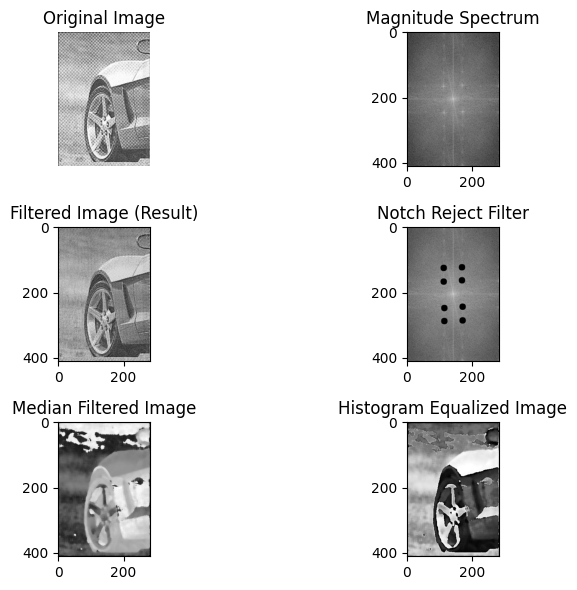

array([[116, 116, 116, ..., 116, 116, 116],
       [116, 116, 116, ..., 116, 116, 116],
       [116, 116, 116, ..., 117, 116, 116],
       ...,
       [116, 116, 122, ..., 163, 138, 116],
       [116, 116, 116, ..., 141, 116, 116],
       [116, 116, 116, ..., 116, 116, 116]], dtype=uint8)

In [56]:
notch_param = [
    (10,112,167),
    (10,112,125),
    (10,168,163),
    (10,168,123),
]

img = cv2.imread("../imgs/car.png", 0)  # 讀取灰階影像
apply_filter(img, notch_param)



[(8, 400, 300)]

Notch Filters (1): 
	d0 = 8     x = 400   y = 300  
	d0 = 8     x = 420   y = 324   (Conjugation)


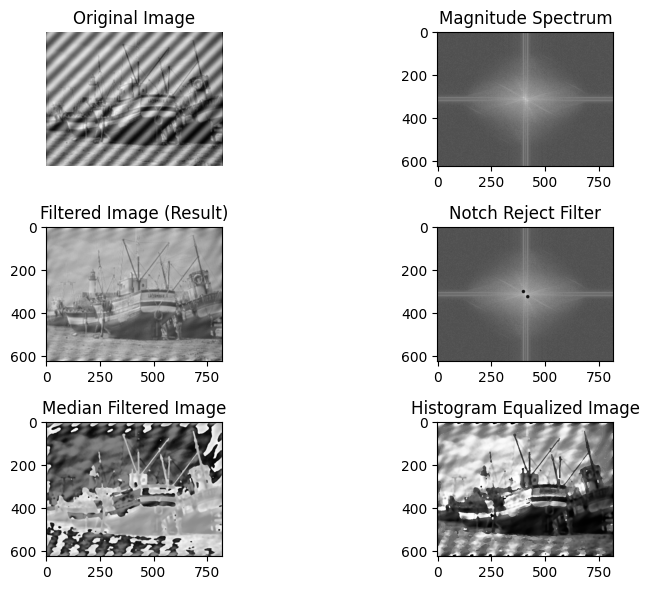

In [57]:
notch_param = [
    (8,400,300), # (d0,x,y)
]
img = cv2.imread("../imgs/ship.png", 0)  
img2 = apply_filter(img, notch_param)


[(8, 400, 300)]

Notch Filters (1): 
	d0 = 8     x = 400   y = 300  
	d0 = 8     x = 420   y = 324   (Conjugation)


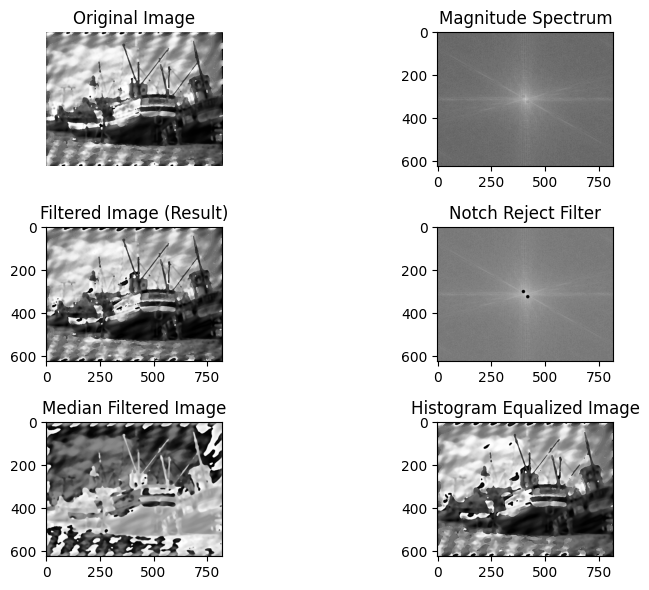

In [58]:

img3 = apply_filter(img2, notch_param)